# Loyalty Program Analysis

# Prerequisites

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker
from scipy.stats import ttest_ind_from_stats
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE

## Tables

In [2]:
skus = pd.read_csv('../../JD_sku_data.csv')
users = pd.read_csv('../../JD_user_data.csv')
clicks = pd.read_csv('../../JD_click_data.csv')
orders = pd.read_csv('../../JD_order_data.csv')
delivery = pd.read_csv('../../JD_delivery_data.csv')
inventory = pd.read_csv('../../JD_inventory_data.csv')
network = pd.read_csv('../../JD_network_data.csv')

## Data Preparation

In [3]:
users = pd.DataFrame(users)
orders = pd.DataFrame(orders)
orders = orders[orders['gift_item'] == 0]
users_orders = pd.merge(orders, users, how='left', on='user_ID' )
plus_orders = users_orders.loc[users_orders['plus'] == 1]
ord_orders = users_orders.loc[users_orders['plus'] == 0]

# Impact of PLUS Memberships

## 1) Data Preparation

In [4]:
plus_orders_impact =  plus_orders.groupby('user_ID').agg({'plus':'count', 'final_unit_price': 'sum'}).reset_index().rename(columns={'plus':'purchase frequency','final_unit_price':'total_expenditure'})
ord_orders_impact =  ord_orders.groupby('user_ID').agg({'plus':'count', 'final_unit_price': 'sum'}).reset_index().rename(columns={'plus':'purchase frequency','final_unit_price':'total_expenditure'})
plus_orders_impact['aov'] = plus_orders_impact["total_expenditure"]/plus_orders_impact["purchase frequency"]
ord_orders_impact['aov'] = ord_orders_impact["total_expenditure"]/ord_orders_impact["purchase frequency"]

## Purchase Frequency

In [5]:
# Define the two samples
sample1 = plus_orders_impact['purchase frequency']
sample2 = ord_orders_impact['purchase frequency']

# Calculate the means and standard deviations of the two samples
mean1 = np.mean(sample1)
mean2 = np.mean(sample2)
std1 = np.std(sample1, ddof=1)
std2 = np.std(sample2, ddof=1)
se1 = np.std(sample1, ddof=1) / np.sqrt(len(sample1))
se2 = np.std(sample2, ddof=1) / np.sqrt(len(sample2))

# Calculate the test statistic and p-value
n1, n2 = len(sample1), len(sample2)

se = np.sqrt(std1**2/n1 + std2**2/n2)

z = (mean1 - mean2) / se
print(mean1 - mean2)
p_value = (1 - stats.norm.cdf(abs(z)))

# Print the test statistic and p-value
print("Test statistic:", z)
print("p-value:", p_value)

# Calculate the critical value for a 95% confidence level
alpha = 0.05
df = n1 + n2 - 2
cv = stats.t.ppf(1 - alpha/2, df)


# Calculate the confidence intervals for each sample
ci1 = (mean1 - cv * se1, mean1 + cv * se1)
ci2 = (mean2 - cv * se2, mean2 + cv * se2)

if p_value < alpha:
    print("Reject null hypothesis. There is a significant difference between the two sample means.")
else:
    print("Fail to reject null hypothesis. There is no significant difference between the two sample means.")
    
print('mean', mean1, 'std dev', std1, 'std err', se1, 'ci', ci1)
print('mean', mean2, 'std dev', std2, 'std err', se2, 'ci', ci2)

0.0715657726950083
Test statistic: 18.769217530842496
p-value: 0.0
Reject null hypothesis. There is a significant difference between the two sample means.
mean 1.1861805278576243 std dev 0.6657377261000181 std err 0.0024689317375866096 ci (1.1813414960700672, 1.1910195596451814)
mean 1.114614755162616 std dev 1.6721512720135265 std err 0.002905655808327333 ci (1.1089197573600684, 1.1203097529651636)


## Average Order Value

In [6]:
# Define the two samples
sample1 = plus_orders_impact['aov']
sample2 = ord_orders_impact['aov']

# Means and standard deviations of the two samples
mean1 = np.mean(sample1)
mean2 = np.mean(sample2)
std1 = np.std(sample1, ddof=1)
std2 = np.std(sample2, ddof=1)
se1 = np.std(sample1, ddof=1) / np.sqrt(len(sample1))
se2 = np.std(sample2, ddof=1) / np.sqrt(len(sample2))

# Test statistic and p-value
n1, n2 = len(sample1), len(sample2)

se = np.sqrt(std1**2/n1 + std2**2/n2)

z = (mean1 - mean2) / se
print(mean1 - mean2)

p_value = (1 - stats.norm.cdf(abs(z)))

print("Test statistic:", z)
print("p-value:", p_value)

# Critical value for a 95% confidence level
alpha = 0.05
df = n1 + n2 - 2
cv = stats.t.ppf(1 - alpha/2, df)

# Confidence intervals for each sample
ci1 = (mean1 - cv * se1, mean1 + cv * se1)
ci2 = (mean2 - cv * se2, mean2 + cv * se2)
# Hypothesis
if p_value < alpha:
    print("Reject null hypothesis. There is a significant difference between the two sample means.")
else:
    print("Fail to reject null hypothesis. There is no significant difference between the two sample means.")
    
print('mean', mean1, 'std dev', std1, 'std err', se1, 'ci', ci1)
print('mean', mean2, 'std dev', std2, 'std err', se2, 'ci', ci2)

9.867409820220985
Test statistic: 33.18515780671655
p-value: 0.0
Reject null hypothesis. There is a significant difference between the two sample means.
mean 94.3755752159518 std dev 74.7288143929754 std err 0.27713667760405286 ci (93.83239568125357, 94.91875475065002)
mean 84.50816539573081 std dev 62.00464853586108 std err 0.10774394050161164 ci (84.29699051994685, 84.71934027151478)


## Average total spend of each customer

In [21]:
# Define the two samples
sample1 = plus_orders_impact['total_expenditure']
sample2 = ord_orders_impact['total_expenditure']

# Means and standard deviations of the two samples
mean1 = np.mean(sample1)
mean2 = np.mean(sample2)
std1 = np.std(sample1, ddof=1)
std2 = np.std(sample2, ddof=1)
se1 = np.std(sample1, ddof=1) / np.sqrt(len(sample1))
se2 = np.std(sample2, ddof=1) / np.sqrt(len(sample2))

# Test statistic and p-value
n1, n2 = len(sample1), len(sample2)

se = np.sqrt(std1**2/n1 + std2**2/n2)

z = (mean1 - mean2) / se
print(mean1 - mean2)
p_value = (1 - stats.norm.cdf(abs(z)))

print("Test statistic:", z)
print("p-value:", p_value)

# Critical value for a 95% confidence level
alpha = 0.05
df = n1 + n2 - 2
cv = stats.t.ppf(1 - alpha/2, df)

# Confidence intervals for each sample
ci1 = (mean1 - cv * se1, mean1 + cv * se1)
ci2 = (mean2 - cv * se2, mean2 + cv * se2)

if p_value < alpha:
    print("Reject null hypothesis. There is a significant difference between the two sample means.")
else:
    print("Fail to reject null hypothesis. There is no significant difference between the two sample means.")
    
print('mean', mean1, 'std dev', std1, 'std err', se1, 'ci', ci1)
print('mean', mean2, 'std dev', std2, 'std err', se2, 'ci', ci2)

16.840852767257232
Test statistic: 20.281566432103663
p-value: 0.0
Reject null hypothesis. There is a significant difference between the two sample means.
mean 111.32254986199308 std dev 198.36371616009808 std err 0.7356447670200233 ci (109.88070829231096, 112.76439143167521)
mean 94.48169709473585 std dev 221.6256490206024 std err 0.38511339561736674 ci (93.72688644734706, 95.23650774212464)


# PLUS Member Demographic

## Data Prep

In [8]:
# no unknown values
users1 = users.drop(users[users['gender']=='U'].index)
users1 = users1.drop(users1[users1['age']=='U'].index)
users1 = users1.drop(users1[users1['marital_status']=='U'].index)
users1 = users1.drop(users1[users1['education']== -1].index)
users1 = users1.drop(users1[users1['user_level']== 10].index)
users1 = users1.drop(users1[users1['education']== -1].index)
users1 = users1.drop(users1[users1['purchase_power']== -1].index)
users1 = users1.drop(users1[users1['city_level']== -1].index)

# Create dummy values for gender, age, marital_status (only strings are categories)
dummy1_vars = pd.get_dummies(users1[['age', 'marital_status', 'gender']])
users1_dummy = users1.drop(['age','gender','marital_status'],axis=1)
users1_dummy = pd.concat([users1_dummy, dummy1_vars], axis=1)

## Random Forest

In [24]:
X = (users1_dummy[['user_level','education','purchase_power','city_level',
                   'age_<=15','age_16-25','age_26-35','age_36-45','age_46-55',
                   'age_>=56','gender_M','gender_F','marital_status_S',
                   'marital_status_M']])
y = (users1_dummy['plus'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Fit the random forest model
model1 = RandomForestClassifier()
model1.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model1.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy:", accuracy)

# Extract the feature importance values
importances = model1.feature_importances_

model6 = pd.DataFrame(importances)*100
model6[0] = model6[[0]].applymap("{:.2f}%".format)
model6 = model6.to_numpy()

attributes = ['user_level','education','purchase_power','city_level',
              'age_<=15','age_16-25','age_26-35','age_36-45','age_46-55',
              'age_>=56','gender_M','gender_F','marital_status_S',
              'marital_status_M']
# Print the feature importance values
print('Random Forest')
for i, importance in enumerate(importances):
    print(attributes[i], "importance:", model6[i,0])

Accuracy: 0.808478006514246
Random Forest
user_level importance: 50.47%
education importance: 21.67%
purchase_power importance: 11.06%
city_level importance: 2.83%
age_<=15 importance: 0.01%
age_16-25 importance: 0.79%
age_26-35 importance: 0.62%
age_36-45 importance: 0.45%
age_46-55 importance: 0.27%
age_>=56 importance: 0.27%
gender_M importance: 3.26%
gender_F importance: 2.69%
marital_status_S importance: 2.59%
marital_status_M importance: 3.02%


#### Importance pie chart

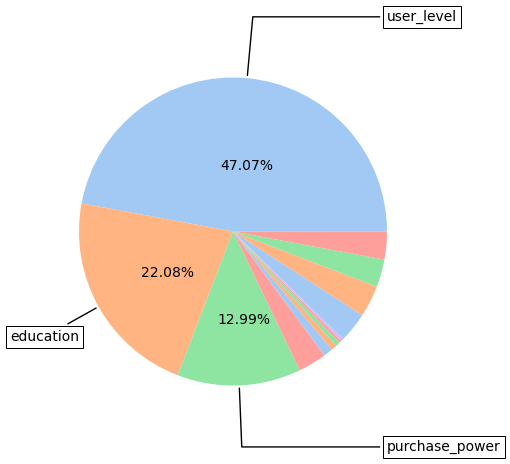

In [10]:
fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))
colors = sns.color_palette('pastel')[0:5]
wedges, texts = ax.pie(model1.feature_importances_, colors = colors)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

# label wedges
for i, p in enumerate(wedges[0:3]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
    ax.annotate(attributes[i], xy=(x, y), xytext=(1*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
       
#percentages
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(
          bbox=bbox_props, zorder=10, va="center")
    
for i, p in enumerate(wedges[0:3]):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))/2
    x = np.cos(np.deg2rad(ang))/2.5
    horizontalalignment = {-1: "left", 1: "left"}[int(np.sign(x))]
    if (i == 1):
        ax.annotate(model6[i,0], xy=(x, y), xytext=(x-0.25, y*1.2))
    else:
        ax.annotate(model6[i,0], xy=(x, y), xytext=(x-0.12, y-0.1))

## Logistic Regression

In [11]:
X = (users1_dummy[['user_level','purchase_power','education']])
y = (users1_dummy['plus'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiate a logistic regression model
model = LogisticRegression(class_weight='balanced')

# fit the model to the training data
model.fit(X_train, y_train)

y_pred = model.predict(X)


# make predictions on the testing data
y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(classification_report(y, model.predict(X)))


print(pd.DataFrame(model.coef_).transpose(), model.intercept_)

odds_ratio = pd.DataFrame(np.exp(model.coef_).transpose(), columns=['OR'])
print(odds_ratio)
print(np.exp(model.intercept_))

Accuracy: 0.7104480915789141
              precision    recall  f1-score   support

           0       0.92      0.68      0.78    242751
           1       0.43      0.80      0.56     73478

    accuracy                           0.71    316229
   macro avg       0.68      0.74      0.67    316229
weighted avg       0.81      0.71      0.73    316229

          0
0  0.937519
1 -0.748886
2  0.648533 [-3.05744555]
         OR
0  2.553638
1  0.472893
2  1.912732
[0.04700762]


# Consumer Behaviour

## Data Preparation

In [12]:
# Tables for product quality
plus_orders_skus = pd.merge(plus_orders, skus, how='left', on=['sku_ID','type'] )
plus_orders_skus = plus_orders_skus.dropna(subset=['attribute1', 'attribute2'])
ord_orders_skus = pd.merge(ord_orders, skus, how='left', on=['sku_ID','type'] )
ord_orders_skus = ord_orders_skus.dropna(subset=['attribute1', 'attribute2'])
# attribute 1
plus_orders_skus_att1 = plus_orders_skus.drop(plus_orders_skus[plus_orders_skus['attribute1'] == '-'].index)
plus_orders_skus_att1['attribute1'] = plus_orders_skus_att1['attribute1'].astype(float)
ord_orders_skus_att1 = ord_orders_skus.drop(ord_orders_skus[ord_orders_skus['attribute1'] == '-'].index)
ord_orders_skus_att1['attribute1'] = ord_orders_skus_att1['attribute1'].astype(float)
# attribute 2
plus_orders_skus_att2 = plus_orders_skus.drop(plus_orders_skus[plus_orders_skus['attribute2'] == '-'].index)
plus_orders_skus_att2['attribute2'] = plus_orders_skus_att2['attribute2'].astype(float)
ord_orders_skus_att2 = ord_orders_skus.drop(ord_orders_skus[ord_orders_skus['attribute2'] == '-'].index)
ord_orders_skus_att2['attribute2'] = ord_orders_skus_att2['attribute2'].astype(float)

#Tables for conversion rate
# Total clicks for each user
clicks1 = (clicks.groupby(['user_ID']).size().reset_index(name='clicks'))
clicks1 = clicks1.drop(clicks1[clicks1['user_ID'] == '-'].index)
# total orders for each user
orders1 = (orders.groupby(['user_ID']).size().reset_index(name='orders'))
# merge
clicks_orders = pd.merge(clicks1, orders1, how='left', on='user_ID' )
# Divide to get conversion rate
clicks_orders['conversion_rate'] =  clicks_orders["orders"]/clicks_orders["clicks"]
clicks_orders = clicks_orders.dropna(subset=['orders', 'clicks'])
#split into plus ord
clicks_orders_users = pd.merge(clicks_orders, users, how='left', on='user_ID' )
plus_clicks_orders = clicks_orders_users[clicks_orders_users['plus'] == 1]
ord_clicks_orders = clicks_orders_users[clicks_orders_users['plus'] == 0]
plus_clicks_orders = plus_clicks_orders.drop(['user_level','first_order_month','plus','gender','age',
                                              'marital_status','education','city_level','purchase_power'],axis=1)
ord_clicks_orders = ord_clicks_orders.drop(['user_level','first_order_month','plus','gender','age',
                                            'marital_status','education','city_level','purchase_power'],axis=1)

## Product Preferences

### attribute 1

In [20]:
# Define the two samples
sample1 = plus_orders_skus_att1['attribute1']
sample2 = ord_orders_skus_att1['attribute1']

# Calculate the means and standard deviations of the two samples
mean1 = np.mean(sample1)
mean2 = np.mean(sample2)
std1 = np.std(sample1, ddof=1)
std2 = np.std(sample2, ddof=1)
se1 = np.std(sample1, ddof=1) / np.sqrt(len(sample1))
se2 = np.std(sample2, ddof=1) / np.sqrt(len(sample2))

# Calculate the test statistic and p-value
n1, n2 = len(sample1), len(sample2)

se = np.sqrt(std1**2/n1 + std2**2/n2)
print(se)
z = (mean1 - mean2) / se
print(mean1 - mean2)
p_value = (1 - stats.norm.cdf(abs(z)))

# Calculate the critical value for a 95% confidence level
alpha = 0.05
df = n1 + n2 - 2
cv = stats.t.ppf(1 - alpha/2, df)

# Calculate the confidence intervals for each sample
ci1 = (mean1 - cv * se1, mean1 + cv * se1)
ci2 = (mean2 - cv * se2, mean2 + cv * se2)

# Print the test statistic and p-value
print("Test statistic:", z)
print("p-value:", p_value)
if p_value < alpha:
    print("Reject null hypothesis. There is a significant difference between the two sample means.")
else:
    print("Fail to reject null hypothesis. There is no significant difference between the two sample means.")
    
print('mean', mean1, 'std dev', std1, 'std err', se1, 'ci', ci1)
print('mean', mean2, 'std dev', std2, 'std err', se2, 'ci', ci2)

0.0026843219008127954
0.040278020371525614
Test statistic: 15.004914410350596
p-value: 0.0
Reject null hypothesis. There is a significant difference between the two sample means.
mean 2.934336258531829 std dev 0.6408666109206181 std err 0.0023918595198233745 ci (2.9296482851669685, 2.9390242318966893)
mean 2.8940582381603033 std dev 0.6787390847496773 std err 0.0012184383876969393 ci (2.891670135238327, 2.8964463410822794)


### attribute 2

In [19]:
# Define the two samples
sample1 = plus_orders_skus_att2['attribute2']
sample2 = ord_orders_skus_att2['attribute2']

# Calculate the means and standard deviations of the two samples
mean1 = np.mean(sample1)
mean2 = np.mean(sample2)
std1 = np.std(sample1, ddof=1)
std2 = np.std(sample2, ddof=1)
se1 = np.std(sample1, ddof=1) / np.sqrt(len(sample1))
se2 = np.std(sample2, ddof=1) / np.sqrt(len(sample2))


# Calculate the test statistic and p-value
n1, n2 = len(sample1), len(sample2)

se = np.sqrt(std1**2/n1 + std2**2/n2)
print(se)
z = (mean1 - mean2) / se
print(mean1 - mean2)
p_value = (1 - stats.norm.cdf(abs(z)))

# Calculate the critical value for a 95% confidence level
alpha = 0.05
df = n1 + n2 - 2
cv = stats.t.ppf(1 - alpha/2, df)

# Calculate the confidence intervals for each sample
ci1 = (mean1 - cv * se1, mean1 + cv * se1)
ci2 = (mean2 - cv * se2, mean2 + cv * se2)

# Print the test statistic and p-value
print("Test statistic:", z)
print("p-value:", p_value)
if p_value < alpha:
    print("Reject null hypothesis. There is a significant difference between the two sample means.")
else:
    print("Fail to reject null hypothesis. There is no significant difference between the two sample means.")
    
print('mean', mean1, 'std dev', std1, 'std err', se1, 'ci', ci1)
print('mean', mean2, 'std dev', std2, 'std err', se2, 'ci', ci2)

0.08804766133922809
1.9626320999707616
Test statistic: 22.29056479318827
p-value: 0.0
Reject null hypothesis. There is a significant difference between the two sample means.
mean 83.63201084314274 std dev 20.704665957042547 std err 0.0794706762200519 ci (83.47625066210936, 83.78777102417611)
mean 81.66937874317198 std dev 20.629819646526265 std err 0.037905174955869536 ci (81.59508571844825, 81.7436717678957)


## Product Price

In [17]:
# Define the two samples
sample1 = plus_orders['final_unit_price']
sample2 = ord_orders['final_unit_price']

# Calculate the means and standard deviations of the two samples
mean1 = np.mean(sample1)
mean2 = np.mean(sample2)
std1 = np.std(sample1, ddof=1)
std2 = np.std(sample2, ddof=1)
se1 = np.std(sample1, ddof=1) / np.sqrt(len(sample1))
se2 = np.std(sample2, ddof=1) / np.sqrt(len(sample2))

# Calculate the test statistic and p-value
n1, n2 = len(sample1), len(sample2)

se = np.sqrt(std1**2/n1 + std2**2/n2)
print(se)
z = (mean1 - mean2) / se
print(mean1 - mean2)
p_value = (1 - stats.norm.cdf(abs(z)))


# Calculate the critical value for a 95% confidence level
alpha = 0.05
df = n1 + n2 - 2
cv = stats.t.ppf(1 - alpha/2, df)

# Calculate the confidence intervals for each sample
ci1 = (mean1 - cv * se1, mean1 + cv * se1)
ci2 = (mean2 - cv * se2, mean2 + cv * se2)

# Print the test statistic and p-value
print("Test statistic:", z)
print("p-value:", p_value)
if p_value < alpha:
    print("Reject null hypothesis. There is a significant difference between the two sample means.")
else:
    print("Fail to reject null hypothesis. There is no significant difference between the two sample means.")
    
print('mean', mean1, 'std dev', std1, 'std err', se1, 'ci', ci1)
print('mean', mean2, 'std dev', std2, 'std err', se2, 'ci', ci2)

0.34825302123133
9.083348912819446
Test statistic: 26.082613384668253
p-value: 0.0
Reject null hypothesis. There is a significant difference between the two sample means.
mean 93.84958465222482 std dev 96.65414803338719 std err 0.3291175307527185 ci (93.20452443075257, 94.49464487369707)
mean 84.76623573940537 std dev 69.17142848052978 std err 0.11384997913035638 ci (84.54309328757525, 84.9893781912355)


## Impulse Buying

In [18]:
# Define the two samples
sample1 = ord_clicks_orders['conversion_rate']
sample2 = plus_clicks_orders['conversion_rate']

# Calculate the means and standard deviations of the two samples
mean1 = np.mean(sample1)
mean2 = np.mean(sample2)
std1 = np.std(sample1, ddof=1)
std2 = np.std(sample2, ddof=1)
se1 = np.std(sample1, ddof=1) / np.sqrt(len(sample1))
se2 = np.std(sample2, ddof=1) / np.sqrt(len(sample2))

# Calculate the test statistic and p-value
n1, n2 = len(sample1), len(sample2)

se = np.sqrt(std1**2/n1 + std2**2/n2)
print(se)
z = (mean1 - mean2) / se
print(mean1 - mean2)
p_value = (1 - stats.norm.cdf(abs(z)))

# Calculate the critical value for a 95% confidence level
alpha = 0.05
df = n1 + n2 - 2
cv = stats.t.ppf(1 - alpha/2, df)

# Calculate the confidence intervals for each sample
ci1 = (mean1 - cv * se1, mean1 + cv * se1)
ci2 = (mean2 - cv * se2, mean2 + cv * se2)

# Print the test statistic and p-value
print("Test statistic:", z)
print("p-value:", p_value)
if p_value < alpha:
    print("Reject null hypothesis. There is a significant difference between the two sample means.")
else:
    print("Fail to reject null hypothesis. There is no significant difference between the two sample means.")
    
print('mean', mean1, 'std dev', std1, 'std err', se1, 'ci', ci1)
print('mean', mean2, 'std dev', std2, 'std err', se2, 'ci', ci2)

0.0011353025317902402
0.0017810866502908362
Test statistic: 1.5688211735794066
p-value: 0.05834480664595709
Fail to reject null hypothesis. There is no significant difference between the two sample means.
mean 0.21438914607047205 std dev 0.2640372890422112 std err 0.00047545970143840705 ci (0.21345725917848848, 0.2153210329624556)
mean 0.2126080594201812 std dev 0.26775042361626183 std err 0.0010309461241972977 ci (0.21058743563950275, 0.21462868320085968)
